# Makemore: part 5

In [1]:
%pip install torch matplotlib

  Using cached matplotlib-3.8.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached typing_extensions-4.11.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.12-py3-none-any.whl.metadata (12 kB)
  Using cached Jinja2-3.1.3-py3-none-any.whl.metadata (3.3 kB)
  Using cached contourpy-1.2.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.51.0-cp312-cp312-macosx_10_9_universal2.whl.metadata (159 kB)
  Using cached kiwisolver-1.4.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
  Using cached pillow-10.3.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached MarkupSafe-2.1.5-cp312-cp312-macosx_10_9_universal2.whl.metadata (3.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-05-03 21:16:11--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-05-03 21:16:11 (7.47 MB/s) - ‘names.txt’ saved [228145/228145]



In [88]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [89]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [90]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [100]:
# Build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [101]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [127]:
# Near copy paste of the layers we have developed in Part 3

class Linear:

    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # ntoe kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps = 1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running `momentum update`)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim = True) # batch mean
            xvar = x.var(dim, keepdim = True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []


class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
    
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n
    
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.out = x
        return self.out
    
    def parameters(self):
        return []

class Sequential:

    def __init__(self, layers):
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [103]:
torch.manual_seed(42)

In [133]:
n_embd = 24
n_hidden = 128

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
    layers[-1].weight *= 0.1 # last layer makes less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

22397


In [134]:
# Same optimization as last time:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track size
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3921
  10000/ 200000: 1.9101
  20000/ 200000: 1.9430
  30000/ 200000: 1.9126
  40000/ 200000: 2.0548
  50000/ 200000: 1.8217
  60000/ 200000: 1.9138
  70000/ 200000: 1.9385
  80000/ 200000: 1.9754
  90000/ 200000: 2.0171
 100000/ 200000: 2.0513
 110000/ 200000: 2.2568
 120000/ 200000: 2.3206
 130000/ 200000: 2.3289
 140000/ 200000: 2.5344
 150000/ 200000: 2.3836
 160000/ 200000: 2.0371
 170000/ 200000: 1.6723
 180000/ 200000: 1.9450
 190000/ 200000: 1.7248


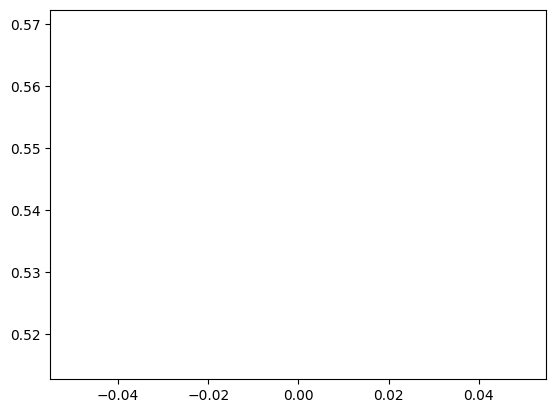

In [132]:
plt.plot(lossi)

Improving the Loss Plot

In [121]:
# Improvement to plotting loss function:
# We can actually grab a tensor, changing the shape into smaller 2-dim tensors, and get the mean
torch.arange(10.).view(-1, 2).mean(1, keepdim = True)

tensor([[0.5000],
        [2.5000],
        [4.5000],
        [6.5000],
        [8.5000]])

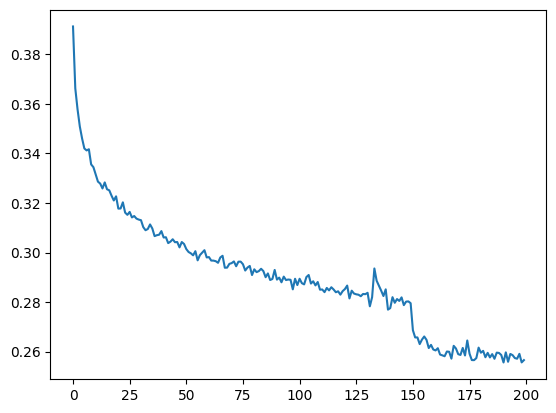

In [122]:
plt.plot(torch.tensor(lossi).view(-1, 1_000).mean(1))

In [110]:
# put layers into eval model
for layer in model.layers:
    layer.training = False

In [123]:
# evaluate the loss
@torch.no_grad() # This decorator disables gradient tracking inside pytorch
def split_loss(split):
    x,y = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7740830183029175
val 1.9846194982528687


In [125]:
# Sample from the model

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim = 1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

/var/folders/s4/4b703c157vd947v77lljf3k40000gn/T/ipykernel_61220/4007245934.py:37: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1807.)
  xvar = x.var(0, keepdim = True) # batch var


RuntimeError: probability tensor contains either `inf`, `nan` or element < 0